In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gsw
import cmocean.cm as cmo
#import cf_xarray as cfxr
import xarray as xr
from skimage.morphology import dilation
from skimage.morphology import disk
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [6]:
geb=xr.open_dataset('../observation/gebco/gebco_2023_n-50.0_s-85.0_w-80.0_e60.0.nc')
geb

<xarray.Dataset>
Dimensions:    (lat: 8400, lon: 33600)
Coordinates:
  * lat        (lat) float64 -85.0 -84.99 -84.99 -84.99 ... -50.01 -50.01 -50.0
  * lon        (lon) float64 -80.0 -79.99 -79.99 -79.99 ... 59.99 59.99 60.0
Data variables:
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

In [3]:
bat=xr.open_dataset('../MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon
bat.coords['nav_lat']=bat.nav_lat
bat['mask_tc']=np.zeros((len(bat.y),len(bat.x)))*(bat.bathy_meter.where(bat.bathy_meter<2500))+1
bat['mask_tc']=bat.mask_tc.where(((bat.mask_tc==1)&(bat.glamt<4.3)&(bat.glamt>0.5)&(bat.gphit>-65.5)),other=0)
mask_tc=bat.mask_tc
mask_tc.load()
mask_tc[173,98]=1
mask_tc[178,109]=0

bat['mask_tc']=mask_tc

mean_bathy = bat.bathy_meter.rolling(x=13,center=True).mean().rolling(y=13,center=True).mean()
bat['mask_tr_all']=np.zeros((len(bat.y),len(bat.x)))*(mean_bathy.where(mean_bathy<3500))+1
bat['mask_tr_all']=bat.mask_tr_all.where(((bat.mask_tr_all==1)&(bat.glamt<8)&(bat.gphit>-66.5)),other=0)
bat['mask_tr']=bat.mask_tr_all-bat.mask_tc

mask_tr=bat.mask_tr


bat['mask_ha'] = xr.DataArray(dilation(bat.mask_tr_all, disk(14)) - bat.mask_tr_all,dims=('y', 'x'))
bat['mask_ha']=bat.mask_ha.where(((bat.mask_ha==1)&(bat.bathy_meter<5000)),other=0)
bat['mask_ha_all'] = bat.mask_ha+bat.mask_tr_all
bat['mask_hatr'] = bat.mask_ha+bat.mask_tr
mask_ha=bat.mask_ha
mask_ha=mask_ha.rename("mask_ha")


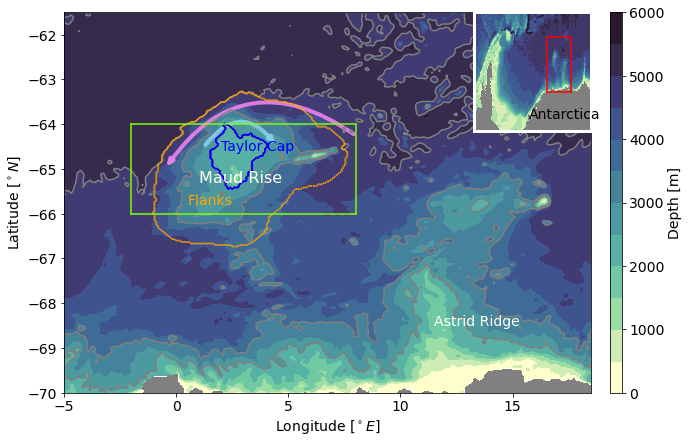

In [18]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10,7))
sgrid = plt.GridSpec(3,5, hspace=0.1,width_ratios=[1,1,1,1,.1],height_ratios=[1,1,1])

ax_map = fig.add_subplot(sgrid[:, :4])
ax_inlay = fig.add_subplot(sgrid[0, 3])
ax_cbar = fig.add_subplot(sgrid[:, 4])

ax=ax_map
bat.bathy_meter.where(bat.bathy_meter<1).plot.contourf(x="nav_lon",y="nav_lat",ax=ax,colors='gray',add_colorbar=False)
cb=bat.bathy_meter.where(bat.bathy_meter>1).plot.contourf(x="nav_lon",y="nav_lat",ax=ax,vmin=0,vmax=6000,levels=13,cmap=cmo.deep,add_colorbar=False)#',add_colorbar=False)
bat.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[2500,3500,5000],ax=ax,colors='gray')

ax.add_patch(mpatches.FancyArrowPatch(posA=(8,-64.25),posB=(-.5,-65),arrowstyle="->, head_width=2,head_length=5",connectionstyle="arc3,rad=.5",color='violet', lw=4,alpha=0.9))
ax.add_patch(mpatches.FancyArrowPatch(posA=(1.25,-64.5),posB=(4.5,-64.5),arrowstyle="->, head_width=2,head_length=5",connectionstyle="arc3,rad=-.65",color='skyblue', lw=4,alpha=0.9))

bat.mask_hatr.plot.contour(x="nav_lon",y="nav_lat",ax=ax,colors='orange',linestyles='--',linewidths=.5)
bat.mask_tc.plot.contour(x="nav_lon",y="nav_lat",ax=ax,colors='b',linestyles='-',linewidths=.7)


ax.plot((-2,-2),(-66,-64),color='chartreuse')
ax.plot((8,8),(-66,-64),color='chartreuse')
ax.plot((-2,8),(-64,-64),color='chartreuse')
ax.plot((-2,8),(-66,-66),color='chartreuse')


ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-61.5)
ax.set_ylabel('Latitude [$^\circ N$]')
ax.set_xlabel('Longitude [$^\circ E$]')
ax.text(.5,-65.8,'Flanks',color='orange',fontsize=14)
ax.text(2,-64.6,'Taylor Cap',color='blue',fontsize=14)
ax.text(11.5,-68.5,'Astrid Ridge',color='ivory',fontsize=14)
ax.text(1,-65.3,'Maud Rise',color='ivory',fontsize=16)
#ax.text(2.5,-70.4,'Queen Maud Land')
ax=ax_inlay

geb.elevation.where(geb.elevation>2).plot.contourf(x="lon",y="lat",ax=ax,colors='gray',add_colorbar=False)
(-1*geb.elevation.where(geb.elevation<2)).plot.contourf(x="lon",y="lat",ax=ax,vmin=0,vmax=6000,levels=13,cmap=cmo.deep,add_colorbar=False)#',add_colorbar=False)
ax.plot([-5,-5],[-61.5,-70.5],color='r')
ax.plot([19.5,19.5],[-61.5,-70.5],color='r')
ax.plot([-5,19.5],[-61.5,-61.5],color='r')
ax.plot([-5,19.5],[-70.5,-70.5],color='r')
ax.set_xlim(-80,40)
ax.set_ylim(-77.0,-57.5)
ax.text(-24,-75,'Antarctica')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.setp(ax.spines.values(), color='w',linewidth=3)
#.set_linewidth(3)
plt.colorbar(cb,cax=ax_cbar,label='Depth [m]')
plt.savefig('./figures/map.jpg',dpi=300)